<a href="https://colab.research.google.com/github/gtsagkatakis/ETCN/blob/main/ETCN_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install tensorflow_addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import os
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import  Activation, Dropout,SpatialDropout1D, Conv3D, ConvLSTM2D, Conv1D, TimeDistributed, Dense, Input, Conv2D, Flatten, MaxPooling2D, Reshape, Conv2DTranspose, BatchNormalization
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image, ImageSequence
import pylab as plt
import random
# from google.colab import drive
# drive.mount('/content/gdrive')
#PATH_OF_DATA= '/content/gdrive/"My Drive"/Autoencoders_model_Myrto/autoencoders'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import sys
from PIL import GifImagePlugin
from skimage.color import rgb2gray

In [46]:
window_TCN=8
window_ConvLSTM=18

In [47]:
# C O M P L E T E   D A T A S E T
frames=[]
for i in range(2003,2020):
  # img = Image.open('/content/gdrive/My Drive/monthly_day/d_%i.gif' %i)
  # img = Image.open('soil_moisture_new\sweden_28_5km_data\%i.gif' %i)
  # img = Image.open('sweden_60_1km\sweden_60_1km_data\%i.gif' %i)
  img = Image.open('/content/drive/My Drive/ETCN data/sweden_28_5km/%i.gif' %i)
  # img = Image.open('america\\america_140_1km\\america_140_1km_data\\%i.gif' %i)
  

  img.load()
    
  for frame in ImageSequence.Iterator(img):
      
    frame_2 = frame.convert('RGB')    #(28, 28, 3)
    frame_2 = np.array(frame_2)       #(28, 28, 3)
    frame_2 = np.sum(frame_2, axis=2) #(28, 28)
    frame_2 = frame_2.reshape(frame_2.shape[0], frame_2.shape[1], 1) #( 28, 28, 1)
    frames.append(frame_2) 
frames = np.array(frames, dtype='uint8')  #(210, 28, 28, 1)
print(frames.max(),frames.min())

254 0


In [48]:
maxi=np.max(frames)
mini=np.min(frames)
frames = (frames-mini)/(maxi-mini) #(209, 28, 28, 1)

In [49]:
# T R A I N   D A T A 
train_frames=frames[0:192,:,:,:] #(209, 28, 28, 1)

In [50]:
X_train_ConvLSTM, y_train_ConvLSTM = [], []
for i in range(len(train_frames)-window_ConvLSTM):
  X_train_ConvLSTM.append(train_frames[i:i+window_ConvLSTM,::,::,::])
  y_train_ConvLSTM.append(train_frames[i+1:i+window_ConvLSTM+1,::,::,::])
X_train_ConvLSTM=np.array(X_train_ConvLSTM)  
y_train_ConvLSTM=np.array(y_train_ConvLSTM) 

In [51]:
X_train_TCN, y_train_TCN = [], []
for i in range(len(train_frames)-window_TCN):
  X_train_TCN.append(train_frames[i:i+window_TCN,::,::,::])
  y_train_TCN.append(train_frames[i+1:i+window_TCN+1,::,::,::])
X_train_TCN=np.array(X_train_TCN)  
y_train_TCN=np.array(y_train_TCN) 

In [52]:
from tensorflow import keras

In [59]:
ae_TCN = keras.models.load_model('/content/drive/MyDrive/ETCN data/ae_TCN.h5')
ae_ConvLSTM = keras.models.load_model('/content/drive/My Drive/ETCN data/ae_ConvLSTM.h5')


In [60]:
num_days_test=12

In [61]:
[n1,n2,n3,n4]=frames.shape

In [62]:
pearsonr_lst_ConvLSTM=np.zeros([num_days_test,1])
mean_absolute_error_lst_ConvLSTM=np.zeros([num_days_test,1])
mean_squared_error_lst_ConvLSTM=np.zeros([num_days_test,1])

In [63]:
pearsonr_lst_TCN=np.zeros([num_days_test,1])
mean_absolute_error_lst_TCN=np.zeros([num_days_test,1])
mean_squared_error_lst_TCN=np.zeros([num_days_test,1])

In [64]:
img_ConvLSTM=np.zeros([num_days_test,n2,n3])
img_gt=np.zeros([num_days_test,n2,n3])
img_TCN=np.zeros([num_days_test,n2,n3])

In [65]:
for i in range(0,num_days_test):

    # T E S T   D A T A
    smps_ConvLSTM=np.arange(192-window_ConvLSTM+i,192+i)
    test_frames_ConvLSTM = frames[smps_ConvLSTM,:,:,:]
    # test_frames_ConvLSTM = (test_frames_ConvLSTM-mini)/(maxi-mini)
    test_frames_ConvLSTM = np.expand_dims(test_frames_ConvLSTM, axis=0)
    
    smps_TCN=np.arange(192-window_TCN+i,192+i)
    test_frames_TCN = frames[smps_TCN,:,:,:]
    # test_frames_TCN = (test_frames_TCN-mini)/(maxi-mini)
    test_frames_TCN = np.expand_dims(test_frames_TCN, axis=0)
    
    
    gt = frames[192+i,:,:,:]
    img_gt[i,:,:]=gt[:,:,0]
    # gt = (gt-mini)/(maxi-mini)
    
    # P R E D I C T I O N
    new_pos_ConvLSTM=ae_ConvLSTM.predict(test_frames_ConvLSTM) #(1, window, 28, 28, num_channels to predict)
    new_pos_TCN=ae_TCN.predict(test_frames_TCN) #(1, window, 28, 28, num_channels to predict)
    
    # P L O T S
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(121)
    # plt.imshow((new_pos[0,-1,:,:,0])) 
    # ax = fig.add_subplot(122)
    # plt.imshow(gt)
    # plt.show()

    # plt.savefig('prediction1.png' )
    
    test=gt.flatten()
    
    img_ConvLSTM[i,:,:]=new_pos_ConvLSTM[0,-1,::,::,0]
    img_TCN[i,:,:]=new_pos_TCN[0,-1,::,::,0]
    
    
    pred_ConvLSTM=new_pos_ConvLSTM[0,-1,::,::,0].flatten()
    pearsonr_lst_ConvLSTM[i]=pearsonr(test, pred_ConvLSTM)[0]
    mean_absolute_error_lst_ConvLSTM[i]=mean_absolute_error(test, pred_ConvLSTM)
    mean_squared_error_lst_ConvLSTM[i]=mean_squared_error(test, pred_ConvLSTM)
    
    pred_TCN=new_pos_TCN[0,-1,::,::,0].flatten()
    pearsonr_lst_TCN[i]=pearsonr(test, pred_TCN)[0]
    mean_absolute_error_lst_TCN[i]=mean_absolute_error(test, pred_TCN)
    mean_squared_error_lst_TCN[i]=mean_squared_error(test, pred_TCN)
    
    # print(pearsonr(test, pred_ConvLSTM))
    # print(mean_absolute_error(test, pred_ConvLSTM))
    # print(mean_squared_error(test, pred_ConvLSTM))

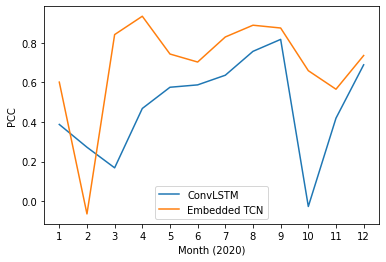

In [66]:
labels = ['1', '2', '3', '4','5','6','7','8','9','10','11','12']
x=np.arange(0,num_days_test)
plt.plot(x,pearsonr_lst_ConvLSTM, label='ConvLSTM')
plt.plot(x,pearsonr_lst_TCN, label='Embedded TCN')
plt.xlabel("Month (2020)")
plt.ylabel("PCC")
plt.xticks(x, labels)
plt.legend()
plt.show()

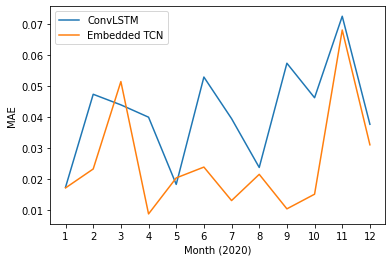

In [67]:
labels = ['1', '2', '3', '4','5','6','7','8','9','10','11','12']
x=np.arange(0,num_days_test)
plt.plot(x,mean_absolute_error_lst_ConvLSTM, label='ConvLSTM')
plt.plot(x,mean_absolute_error_lst_TCN, label='Embedded TCN')
plt.xlabel("Month (2020)")
plt.ylabel("MAE")
plt.xticks(x, labels)
plt.legend()
plt.show()

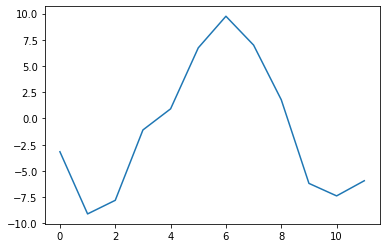

In [68]:
d=np.mean(img_ConvLSTM*maxi,axis=-1)
e=np.mean(d,axis=-1)
e=(e-173)/5
plt.plot(e,label='ConvLSTM')
# plt.show()

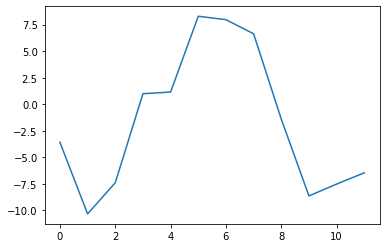

In [69]:
d=np.mean(img_TCN*maxi,axis=-1)
e=np.mean(d,axis=-1)
e=(e-173)/5
plt.plot(e,label='Embedded TCN')
# plt.show()

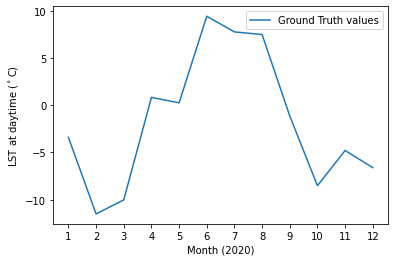

In [70]:
d=np.mean(img_gt*maxi,axis=-1)
e=np.mean(d,axis=-1)
e=(e-173)/5
plt.plot(e,label='Ground Truth values')
plt.legend()
plt.xticks(x, labels)
plt.xlabel("Month (2020)")
plt.ylabel("LST at daytime ($^\circ$C) ")
plt.show()

In [71]:
from scipy import stats
# stats.ttest_ind((img_ConvLSTM).flatten(),(img_TCN).flatten())
print(stats.ttest_rel((img_ConvLSTM-img_gt).flatten(),(img_TCN-img_gt).flatten()))
# print(stats.ttest_rel((img_ConvLSTM[:,:,:]).flatten(),(img_TCN[:,:,:]).flatten()))

Ttest_relResult(statistic=26.832519457697792, pvalue=6.923948510657451e-153)
